In [3]:
# Code source: https://github.com/scikit-image/skimage-demos/tree/master/pano
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
# Only Opencv with version 3.4 support the SIFT fuction
!pip install opencv-python==3.4.11.43
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


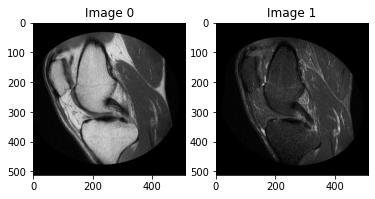

In [4]:
I0 = cv2.imread("/content/drive/My Drive/MM803/Assignment2/knee1.bmp")
pano0 = cv2.cvtColor(I0,cv2.COLOR_BGR2GRAY)
I1 = cv2.imread("/content/drive/My Drive/MM803/Assignment2/knee2.bmp")
pano1 = cv2.cvtColor(I1,cv2.COLOR_BGR2GRAY)

%matplotlib inline
fig=plt.figure()
plt.subplot(121)
plt.imshow(I0,cmap="gray")
plt.title("Image 0")
plt.subplot(122)
plt.imshow(I1,cmap="gray")
plt.title("Image 1")
plt.show()

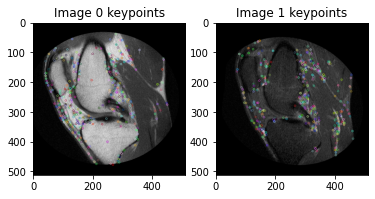

In [5]:
# Using Scale Invariant Feature Transform (SIFT) to distinctive image features
sift = cv2.SIFT_create(400)

# Detect keypoints in pano0 using OpenCV sift detect function
kp0, descriptors0 = sift.detectAndCompute(pano0,None)

# Detect keypoints in pano1 using OpenCV sift detect function
kp1, descriptors1 = sift.detectAndCompute(pano1,None)

fig=plt.figure()
plt.subplot(121)
plt.imshow(cv2.drawKeypoints(pano0,kp0,None),cmap="gray")
plt.title("Image 0 keypoints")
plt.subplot(122)
plt.imshow(cv2.drawKeypoints(pano1,kp1,None),cmap="gray")
plt.title("Image 1 keypoints")
plt.show()

In [6]:
from skimage.feature import match_descriptors

# Match descriptors between images
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)

In [7]:
# Restore the openCV style keypoints into a 2d array type keypoints
keypoints0 = []
a = 0
for i in kp0:
    keypoints0.append(list(kp0[a].pt)[::-1])
    a += 1

keypoints0 = np.array(keypoints0)

keypoints1 = []
b = 0
for j in kp1:
    keypoints1.append(list(kp1[b].pt)[::-1])
    b += 1

keypoints1 = np.array(keypoints1)

(0.0, 1024.0, 512.0, 0.0)

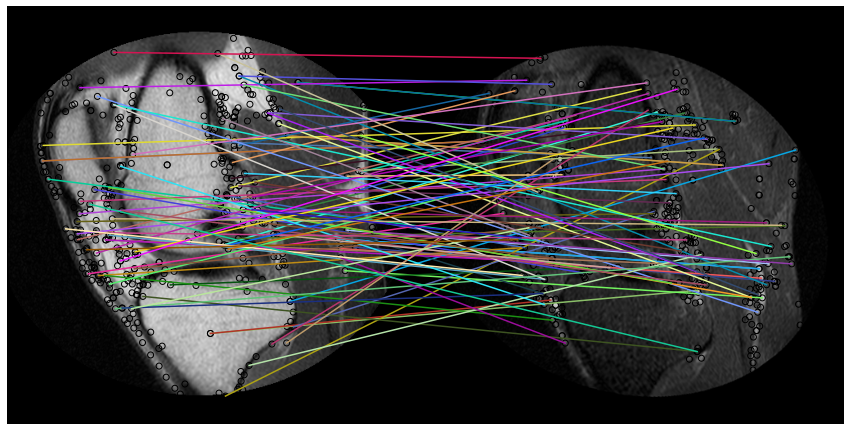

In [8]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, I0, I1, keypoints0, keypoints1, matches01)
ax.axis('off')

In [9]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Select keypoints from 
#   * source (image to be registered): pano1
#   * target (reference image): pano0
src = keypoints1[matches01[:, 1]][:, ::-1]
dst = keypoints0[matches01[:, 0]][:, ::-1]

# Decided the best parameter for this case with residual_threshold=5, and max_trials=1500
model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=5, max_trials=1500)


In [10]:
print(model_robust01)

<ProjectiveTransform(matrix=
    [[ 1.00820746e+00,  1.52080945e-01, -5.13488196e+01],
     [-2.41533516e-01,  1.11528108e+00,  2.74782292e+01],
     [ 1.90343532e-05,  9.39059832e-05,  9.70724465e-01]])>


(0.0, 1024.0, 512.0, 0.0)

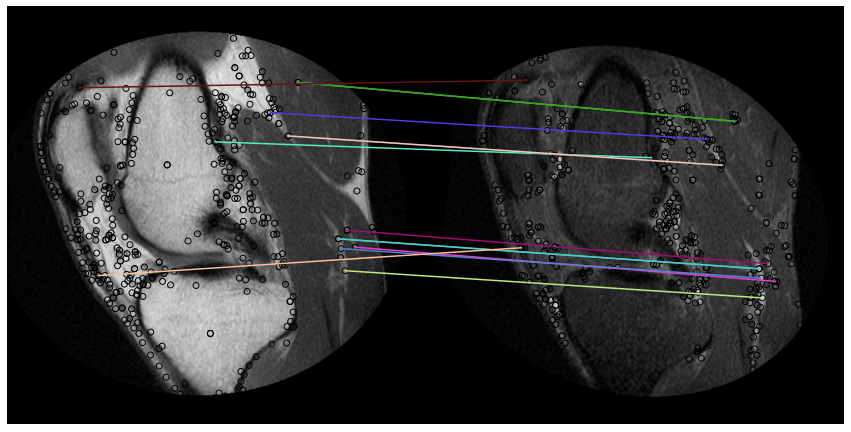

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, I0, I1, keypoints0, keypoints1, matches01[inliers01])

ax.axis('off')

In [14]:
from skimage.transform import SimilarityTransform

# Shape registration target
r, c = pano0.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, corners))

# The overally output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

In [15]:
print(output_shape)

[686 581]


In [16]:
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)


# Warp pano1 to pano0 using 3rd order interpolation
transform01 = (model_robust01 + offset1).inverse  
I1_warped = warp(I1, transform01, order=3,
                    output_shape=output_shape, cval=-1)

I1_mask = (I1_warped != -1)  # Mask == 1 inside image
I1_warped[~I1_mask] = 0      # Return background values to 0


# Translate pano0 into place
I0_warped = warp(I0, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

I0_mask = (I0_warped != -1)  # Mask == 1 inside image
I0_warped[~I0_mask] = 0      # Return background values to 0


In [ ]:
print(I1_warped.shape)

(625, 613, 3)


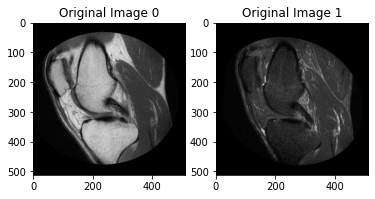

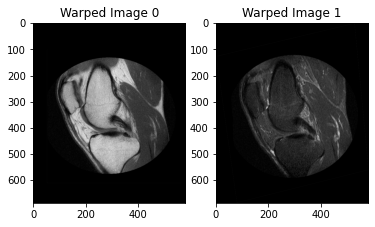

In [17]:
%matplotlib inline
fig=plt.figure()
plt.subplot(121)
plt.imshow(I0,cmap="gray")
plt.title("Original Image 0")
plt.subplot(122)
plt.imshow(I1,cmap="gray")
plt.title("Original Image 1")
plt.show()

%matplotlib inline
fig=plt.figure()
plt.subplot(121)
plt.imshow(I0_warped,cmap="gray")
plt.title("Warped Image 0")
plt.subplot(122)
plt.imshow(I1_warped,cmap="gray")
plt.title("Warped Image 1")
plt.show()

In [18]:
# Add the images together. This could create dtype overflows!
# We know they are are floating point images after warping, so it's OK.
merged = (I0_warped + I1_warped)

# Track the overlap by adding the masks together
overlap = (I0_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           I1_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

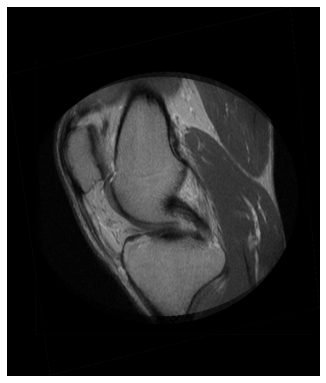

In [19]:
fig, ax = plt.subplots(figsize=(5, 10))

ax.imshow(normalized,cmap="gray")

plt.tight_layout()
ax.axis('off');